# Making a baseline model

In this notebook I create some basic models. These will be useful to compare future model performance to and to see how easily the targets can be predicted without much preprocessing or hyperparameter tuning.

I will train it on the training set and test it on the validate set.  (To prevent overfitting and data leak, and so that the output of my modelling process is a fair approximation for how the models can perform on unseen data, I will only apply my final model to the test set.)

One thing I want to check with these baseline models is whether moderate performance can be achieved on the most useful classifiers using only the most basic preparation. To this end I will use:
- The concatenated annotation targets (each target is a particular practice and a particular party). This is very useful for understanding in more detail how a company uses user data so if it can be predicted without building more complex classifiers then this will be a big win.
- The sentence-level dataframe (produced in the EDA notebook). This provides more data to work with. This also could help test Story et al.'s prediction that training classifiers at the sentence level would be more helpful.

<h3>Steps in this notebook:<span class="tocSkip"></span></h3>

- Loading the data and splitting into Train/Validate
- Vectorize the sentences.  I will generate tokens using each word and bigrams.
- Train a model to classify only *Email address 1st Party*.
- Evaluate the results
- Train models to classify all five targets identified in the previous notebook and evaluate the results

I will use logistic regression for the baseline model because:
- it is not overly complex
- does not require vast runtime to train or make predictions
- it is easy to interpret
- has shown to perform fairly in a wide range of domains
- can sometimes perform fairly even with little pre-processing
- also, logistic regression is a moderately robust model – it performs well even when there are outliers and does not change too much when applied to a new dataset.

Imports:

In [1]:
import pandas as pd
from pandas import json_normalize
import yaml
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm

import nltk

import sys
from collections import defaultdict
from collections import Counter

import priv_policy_manipulation_functions as priv_pol_funcs

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression 

from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn')

# Loading the data

In [3]:
all_annot_sentence_df_annots = pd.read_pickle('objects/all_annot_sentence_df_annots.pkl')

Dropping the modality information as I am not training a classifier for it right now

In [4]:
modelling_df = all_annot_sentence_df_annots.drop(columns=['annotations']) 

In [5]:
names_of_targets_of_interest = ['Contact_E_Mail_Address_1stParty', 'Contact_E_Mail_Address_3rdParty', 'Contact_Address_Book_1stParty', 
     'Contact_Postal_Address_3rdParty', 'Location_1stParty']

# Train/validate split

In [6]:
# splitting the whole dataframe into a train and a validate dataframe
validate_df = modelling_df[ modelling_df['policy_type'] == "VALIDATION" ].copy()
baseline_train_df = modelling_df[ (modelling_df['policy_type'] == "TRAINING") ].copy()

Train: filtering to only the current target columns, aka, practices, of interest

In [7]:
baseline_train_target = baseline_train_df[names_of_targets_of_interest].copy() 

## Splitting into X (input data) and Y (target) for each of the train and validate sets:

**Train**

Defining the individual target columns:

In [8]:
# I'm not sure why I used the column index instead of the column name
y_train_Contact_E_Mail_Address_1stParty = baseline_train_target.iloc[:,0]
y_train_Contact_E_Mail_Address_3rdParty = baseline_train_target.iloc[:,1]
y_train_Contact_Address_Book_1stParty = baseline_train_target.iloc[:,2]
y_train_Contact_Postal_Address_3rdParty = baseline_train_target.iloc[:,3]
y_train_Location_1stParty = baseline_train_target.iloc[:,4]

# list of all the above target columns:
list_of_train_targets = [y_train_Contact_E_Mail_Address_1stParty, y_train_Contact_E_Mail_Address_3rdParty, 
                         y_train_Contact_Address_Book_1stParty, y_train_Contact_Postal_Address_3rdParty, 
                         y_train_Location_1stParty]

**Validate**

Filtering to only the current target columns(practices) of interest

In [9]:
validate_target = validate_df[names_of_targets_of_interest].copy()

Defining the individual target columns and grouping them into a list:

In [10]:
y_validate_Contact_E_Mail_Address_1stParty = validate_target.iloc[:,0]
y_validate_Contact_E_Mail_Address_3rdParty = validate_target.iloc[:,1]
y_validate_Contact_Address_Book_1stParty = validate_target.iloc[:,2]
y_validate_Contact_Postal_Address_3rdParty = validate_target.iloc[:,3]
y_validate_Location_1stParty = validate_target.iloc[:,4]

list_of_validate_targets = ['y_validate_Contact_E_Mail_Address_1stParty', 'y_validate_Contact_E_Mail_Address_3rdParty', 
                        'y_validate_Contact_Address_Book_1stParty', 'y_validate_Contact_Postal_Address_3rdParty', 
                        'y_validate_Location_1stParty']

list_of_target_variables = [y_validate_Contact_E_Mail_Address_1stParty, y_validate_Contact_E_Mail_Address_3rdParty, 
                           y_validate_Contact_Address_Book_1stParty, y_validate_Contact_Postal_Address_3rdParty, 
                           y_validate_Location_1stParty]

# Tokenize & Vectorize

(Mechanics of tokenization and vecotorization explained in the previous EDA notebook)

In [11]:
# nltk.download('stopwords') # must download the stopwords if not already done so
from nltk.corpus import stopwords 
nltkstopwords = stopwords.words('english')

stemmer = nltk.stem.PorterStemmer()

bagofwords = CountVectorizer(stop_words=nltkstopwords,
                             ngram_range=(1,2),
                            tokenizer=lambda sentence: [ stemmer.stem(word) for word in sentence.split(' ') ])

Fit on the training data and use it to transform both train and validate datasets:

In [12]:
bagofwords.fit(baseline_train_df['sentence_text'])
baseline_train_tokens = bagofwords.transform(baseline_train_df['sentence_text']) 
validate_tokens = bagofwords.transform(validate_df['sentence_text']) 

/Users/chinchcliffe/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/chinchcliffe/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', "it'", 'onc', 'onli', 'ourselv', "she'", "should'v", 'themselv', 'thi', 'veri', 'wa', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  warnings.warn(


# Modelling – Fit logistic regression

To start with I will just look at one target – E_Mail_Address_1stParty.  This is a good classifier to compare others too as it is the one with the most data and this practice commonly features in privacy policies.

I will run the model and evaluate the results on E_Mail_Address_1stParty.  Then I will run models on all five targets and review the results.

### E_Mail_Address_1stParty – train score

Instantiate logistic regression model:

In [13]:
logistic_regression_model = LogisticRegression(max_iter = 2000, multi_class='ovr')

Fit the model to the training data.  The training data is all tokenized.

In [14]:
logistic_regression_model.fit(baseline_train_tokens, y_train_Contact_E_Mail_Address_1stParty)

LogisticRegression(max_iter=2000, multi_class='ovr')

Score the model.  How well does it perform on the data it was trained on?  A high score could be a sign of overfitting.

In [15]:
logistic_regression_model.score(baseline_train_tokens, y_train_Contact_E_Mail_Address_1stParty)

0.9943714821763602

This is an extremely high score so it's possible that the model has overfit to this data badly. One way to reduce this would be to use cross validation.  We will see the extent of overfitting later by comparing to the validate score.

In [16]:
y_predictions = logistic_regression_model.predict(baseline_train_tokens)

cf_matrix = confusion_matrix(y_train_Contact_E_Mail_Address_1stParty, y_predictions)
cf_df = pd.DataFrame(
    cf_matrix, columns=["Predicted Negative", "Predicted Positive"], index=["True Negative", "True Positive"])
cf_df

,Predicted Negative,Predicted Positive
True Negative,3113,1
True Positive,23,1127


We can see from the confusion matrix that the model has significantly more false negatives than false positives.

In [17]:
print(classification_report(y_train_Contact_E_Mail_Address_1stParty, y_predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3114
           1       1.00      0.98      0.99      1150

    accuracy                           0.99      4264
   macro avg       1.00      0.99      0.99      4264
weighted avg       0.99      0.99      0.99      4264



Reading the classification report, those false negatives and false negatives are reflected in the extremely high recall score for class 0 (not present) and lower recall score for class 1 (target present).  I will discuss the interpretation of this when looking at the validation results.

### E_Mail_Address_1stParty – validation score

In [18]:
y_validate_email_1st_preds = logistic_regression_model.predict(validate_tokens)

In [19]:
logistic_regression_model.score(validate_tokens, y_validate_Contact_E_Mail_Address_1stParty)

0.8863898500576701

Although the validation accuracy is 10% lower and the model is definitely overfitting, this score is still moderately good.  The model is correct in 90% of cases on data it hasn't seen.  The class is imbalanced so let's see how this breaks down further.

In [20]:
cf_matrix = confusion_matrix(y_validate_Contact_E_Mail_Address_1stParty, y_validate_email_1st_preds)
cf_df = pd.DataFrame(
    cf_matrix, columns=["Predicted Negative", "Predicted Positive"], index=["True Negative", "True Positive"])
cf_df

,Predicted Negative,Predicted Positive
True Negative,1292,54
True Positive,143,245


The model maintains good ability to identify negative cases (which is unsurprising given that the data has more negative cases) but doesn't do so well at identifying the positive case.

In [21]:
print(classification_report(y_validate_Contact_E_Mail_Address_1stParty, y_validate_email_1st_preds))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1346
           1       0.82      0.63      0.71       388

    accuracy                           0.89      1734
   macro avg       0.86      0.80      0.82      1734
weighted avg       0.88      0.89      0.88      1734



Due to the imbalance in the class (and all classes), I expect positive recall to be lower, so a higher recall score would be a good sign for the model.  This is not what we see here. So in a case where it is particularly important, in the case when a sentence mentions what the 1st party did with user's E-Mail Address, that the model finds it, this model would not be useful.

Story et al. are particularly interested in looking for cases where the target is NOT present in the policy, because this could be a case where a company is conducting some privacy data practice without detailing it in the policy (a violation).  So for their purposes, less false positives (a higher recall for the 0 class, aka *negative recall*) is more important.

One way to address the lower positive class recall, which is common with imbalanced classes, is to change the clasification threshold.  The logistic regression model makes a prediction that each observation is one class or the other. Generally the threshold is 50%: if the model predicts class 1 with more than 50% likelihood, it makes the hard prediction that it is class 1. But we can change this threshold from 50% to see whether that improves the metric.

From there we can plot how the false negative and false positive scores change while varying the threshold.  The standard form of this graph is the ROC (Receiver operating characteristic).  And the total area under the ROC curve is a metric for the overall performance of the model. This area under the curve (AUC) metric is a common way to assess model performance.

/Users/chinchcliffe/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


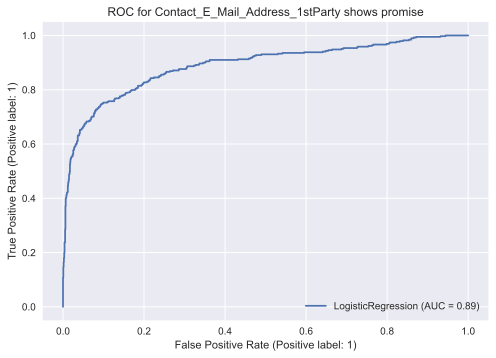

In [22]:
plot_roc_curve(logistic_regression_model, validate_tokens, y_validate_Contact_E_Mail_Address_1stParty)
plt.title("ROC for Contact_E_Mail_Address_1stParty shows promise")
plt.show()

The AUC score shows how we could change the threshold get different performance across the classes.

The AUC score can also be calculated with a function. I am unsure why the score below gives a different result to the one stated in the ROC graph above.

In [23]:
roc_auc = roc_auc_score(y_validate_Contact_E_Mail_Address_1stParty, y_validate_email_1st_preds)
roc_auc

0.7956622141204944

The AUC scores (both?) are not too low, and the curve is getting towards the top left corner and is the right shape, so I think with more tuning a classifier of good performance could be trained using this data.

# Model on all five targets

To evaluate the scores in the remaining targets I will just look at positive precision and recall.

These will help answer questions around:
- When the classifier predicts that the data practice is present, how often is it right? (Precision)
- When the practice is present, how likely is it to be predicted? (Recall)

I am interested in these answers because: 
- If I want to warn users that a privacy policy contains a dangerous data practice, and I train a classifier to flag whenever this is present, I will lose a lot of reputation if the classifier is found to be wrong often.
- If I as a user are particularly worried about a practice being conducted, then if that practice is in a policy, I want the classifier to indicate it.

Using similar steps to the above looping through all targets:

In [24]:
precision_list = []
recall_list = []
for i in range(5):
    logistic_regression_model.fit(baseline_train_tokens, list_of_train_targets[i])
    predics = logistic_regression_model.predict(validate_tokens)
    prec = precision_score(list_of_target_variables[i], predics)
    recs = recall_score(list_of_target_variables[i], predics)
    precision_list.append(prec)
    recall_list.append(recs)

In [25]:
precision_list = [round(item, 3) for item in precision_list]
recall_list = [round(item, 3) for item in recall_list]
prec_rec = np.array([precision_list, recall_list]).T
eval_scores = pd.DataFrame(columns=['Precision', 'Recall'], index=names_of_targets_of_interest, data=prec_rec) 

In [26]:
eval_scores

,Precision,Recall
Contact_E_Mail_Address_1stParty,0.819,0.631
Contact_E_Mail_Address_3rdParty,0.500,0.055
Contact_Address_Book_1stParty,0.657,0.277
Contact_Postal_Address_3rdParty,0.667,0.091
Location_1stParty,0.832,0.485


As expected we see higher scores for classifiers for which there is more data.  Precision is generally much higher than recall because of the class imbalance.  

The recall for the two third party classifiers is less than 0.1.  This is extremely low so I think that even with different ways of looking at this, better pre-processing and looking for better models, it will be difficult to get good classifiers.  In fact, Story et al. do not train a classifier to predict postal address, and score an F1 score (harmonic mean of precision and recall) of only 35% for Contact Email Address 3rdParty when classifying whether a whole policy contains this.

I feel that these practices (Contact_E_Mail_Address_3rdParty and Contact_Postal_Address_3rdParty) are of particular importance for user data privacy.  They are the only 3rd party practices I am looking at and relate to threats such as the common occurrence of getting spam marketing emails and the dangers of identity fraud, receiving unwelcome post or unwelcome guests.  The fact that these are particularly difficult to predict means that this approach towards privacy policies may not be fruitful in researching these practices in detail or in mitigating these risks.

Another observation around modelling and natural language processing is that the recall for Location is much lower than for Email Address 1st party, despite the precision being similar.  This may be because of the higher correlation between key words like "email" and the Contact_E_Mail_Address, where as "location" is a more vague concept that can be spoken about in different ways. 

# Conclusion

Overall I believe that using this data, there is promise to train classifiers for certain performance for some of these practices, but not for all.

I will now continue to explore Story et al.'s approach by attempting to replicate their work.